# A demonstration of the autonomous decision making system

### The intent of this notebook is to demonstrate the use of a decision making system for the Nova Rover. In order to do this we need to: 
1. Simulate the rover's motion and detections in a simulated environment.
2. Simulate detected obstacles and targets
3. Demonstrate decision making system that avoids 

In [413]:
import numpy as np
import math
import matplotlib.pyplot as plt

class rover:
    def __init__(self,x,y,th):
        # Initial conditions selected arbitrarily
        self.x = x
        self.y = y 
        self.theta = th   
        self.v = 0
    def updatestate(self,state):
        self.x = state[0]
        self.y = state[1]
        self.theta = state[2]
        self.v = state[3]

Now that the class of the rover has been defined, we will implement an a* based pathfinding algorithm to search over the known grid. 
We begin by defining a grid that exists as the rovers main knowledge base. Called World ($W$)
Where, $W$ is a 2D array used to denote the "threat" or "opportunity" level of the grid square. All grid sqaures correspond to real world positions, each grid square has width $w$, which can be tuned for the application. 

Each cell has a value $W_{x,y} \in \mathbb{R}$ 

Lower values are an opportunity, Higher values are a threat. 
The algorithm for searching the space works as follows.
1. **Initialise** If the rover has just begun a new search for a target (could be a tennis ball) then initialise the array with the following. If this is not true skip this step. 
    1. Generate an array of zeros with height and width defined by the distance between the target and the rover as estimated by the rovers localization algorithm and the competition supplied gps coordinates. Ensure sufficient for overshoot. For example if it is $X$ m to the tennis ball and square width is defined as $w$ then $n = \frac{X}{w}$ is the height and width of the array. 
    2. Place a guassian function at the tennis ball gps location with amplitude $A = -1$ and each cell within range $3 \sigma$ from the centre calculate its value from that guassian. 
    


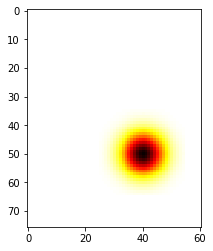

In [414]:
## Initialisation routine example in python. 

def normpdf(x, mean, sd):
    var = float(sd)**2
    denom = (2*math.pi*var)**.5
    num = math.exp(-(float(x)-float(mean))**2/(2*var))
    return num/denom
def applyGaussianToField(field,weight,x,y,sigma):
    for i in range(y-3*sigma,y+3*sigma):            
        for j in range(x-3*sigma,x+3*sigma):
            cart_distance = math.sqrt((x-j)**2 +(y-i)**2)
            if i in set(range(0,field.shape[0])) and j in set(range(0, field.shape[1])):
                field[i,j] = weight* normpdf(cart_distance,0,sigma) +field[i,j] 
    return field
def Initialise_tennis_ball_search():
    suspected_x, suspected_y = (40,50)
    rover_x, rover_y = (0,0)
    width = 1 # width of a grid cell = 0.1m (tuneable)
    sigma = 5 # standard deviation of the guassian
    fudgeFactor =1.5 ## Tuneable!
    x_size = int (fudgeFactor*(suspected_x-rover_x)+ 1)
    y_size = int (fudgeFactor*(suspected_y-rover_y)+ 1)
    RoverWorld = np.ones((y_size,x_size))
    
    RoverWorld = applyGaussianToField(RoverWorld,-20.0,suspected_x,suspected_y,5)
    return RoverWorld


arr = Initialise_tennis_ball_search()
plt.imshow(arr, cmap='hot', interpolation='nearest')
plt.show()

This is what the rover will know about the world when it first starts up, it will identify the cell of highest interest (Lowest cell index value) and use a minimum cost pathfinding approach
2. **Remap** the rover will scan the environment with its sensors and re update the map using its current estimates. 
    1. Detect any obstacles and/or opportunities with a certain confidence level $p$ and with a certain confidence on the localisation $\sigma_ij$. 
    2. Update the _RoverWorld_ map with the targets and opportunities, scaling them appropriately based on cost. 
3. **Pathfind** Once the map has been updated, recompute the path forward using the new information. 
4. **Move** and iterate the process. 


In [415]:
# Defining obstacles notation size x position y position sigma
obstacles = [(100,20,20,5),(100,20,40,5),(200,40,20,10)]


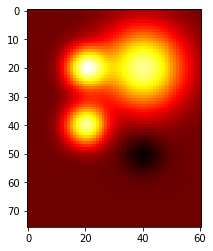

In [416]:
for obstacle in obstacles:
    arr = applyGaussianToField(arr,*obstacle)
    
plt.imshow(arr, cmap='hot', interpolation='nearest')
plt.show()

This is an example of how the world will hopefully look from the perspective of the Rover while it is navigating. The remaining task is to pathfind over that graph. We will use the astar algorithm developed by MSP for the 2018 rover to accomplish this. See code below (however, the datails are not super relevant for our purposes here). 

Before anything else we need to select an objective of the rover, for simplicity we will use the minimum of the graph, something more complex (intelligent) could concievably be used though. 

In [417]:
from math import sqrt, inf
from itertools import product

def euclidean_heuristic_cost(curr, end):
    """
    Estimates cost from curr (x0,y0) to end (x1,y1) using Euclidean
    distance.
    """
    curr_x, curr_y = curr
    end_x, end_y = end
    return sqrt((curr_x-end_x)**2 + (curr_y-end_y)**2)

def manhattan_heuristic_cost(curr, end):
    """
    Estimates cost from curr (x0,y0) to end (x1,y1) using Manhattan
    distance.
    """
    curr_x, curr_y = curr
    end_x, end_y = end
    return abs(curr_x-end_x) + abs(curr_y-end_y)

def reconstruct_path_to_destination(prev, end):
    """
    Constructs an in-order sequence of (x,y) coordinates (list of tuples)
    to the end destination using the mapping from nodes to their predecessors
    (prev).
    """
    path = [end]
    curr = end
    while curr in prev.keys():
        curr = prev[curr]
        path.insert(0, curr)
    return path

def get_successors(node, grid):
    """
    The neighbors of a cell (node) in the grid are the 8-surrounding cells.
    """
    successors = []

    node_x, node_y = node
    n_rows = len(grid)
    n_cols = len(grid[0])

    for dx, dy in product([-1,0,1],[-1,0,1]):
        # skip the current node itself
        if (dx == 0 and dy == 0):
            continue

        x = node_x + dx
        y = node_y + dy

        if (0 <= x < n_rows and 0 <= y < n_cols):
            cost = grid[y][x]
        else:
            # put infinite penalty on successors that would take us off the edge of the grid
            cost = inf

        successors.append( ((x, y), cost) )

    return successors

def node_with_min_fscore(open_set, f_cost): # open_set is a set (of cell) and f_cost is a dict (with cells as keys) 
    """
    Find the cell in open set with the smallest f score.
    """
    f_cost_open = dict([a for a in f_cost.items() if a[0] in open_set])
    return min(f_cost_open, key=f_cost_open.get)

def a_star(grid, start, end, heuristic_cost=manhattan_heuristic_cost):
    """
    Implementation of A Star over a 2D grid. Returns a list of waypoints
    as a list of (x,y) tuples.

    Input:
    : grid, 2D matrix
    : start, (x,y) tuple, start position
    : end, (x,y) tuple, end destination

    Output:
    : waypoints, list of (x,y) tuples
    """
    # the set of cells already evaluated
    closed_set = set()

    # the set of cells already discovered
    open_set = set()
    open_set.add(start)

    # for each cell, mapping to its least-cost incoming cell
    prev = {}
   
    # for each node, cost of reaching it from start (g_cost) 
    # for each node, cost of getting from start to dest via that node (f_cost)
    #   note: cell->dest component of f_cost will be estimated using a heuristic
    g_cost = {}
    f_cost = {}
    for r in range(len(grid)):
        for c in range(len(grid[0])):
            cell = (r, c)
            g_cost[cell] = inf
            f_cost[cell] = inf
    g_cost[start] = 0
    f_cost[start] = heuristic_cost(start, end)

    while open_set:
        # node in open set with min fscore
        curr = node_with_min_fscore(open_set, f_cost)
        
        # if we've reached the destination
        if curr == end:
            return reconstruct_path_to_destination(prev, curr)

        open_set.remove(curr)
        closed_set.add(curr)
        
        for neighbor, cost in get_successors(curr, grid):
            # ignore neighbors which have already been evaluated
            if neighbor in closed_set:
                continue

            curr_g_score =  g_cost[curr] + cost
            # add neighbor to newly discovered nodes
            if neighbor not in open_set:
                open_set.add(neighbor)

            # if we've already got a lower g_score for neighbor, then move on
            elif curr_g_score >= g_cost[neighbor]:
                continue

            prev[neighbor] = curr
            g_cost[neighbor] = curr_g_score
            f_cost[neighbor] = g_cost[neighbor] + heuristic_cost(neighbor, end)

    # if we get to this point, it's not possible to reach the end destination
    return []


In [418]:
min_index_y, min_index_x = np.argwhere(arr == np.min(arr))[0]
path = a_star(arr,(0,0),(min_index_x, min_index_y))

We now have a path from the beginning point (0,0) to the end target point (50,50). For simplicity we are assuming that the target is exactly at the place where it is most likely to be. Obviously this does not reflect reality, but we will build to that. The next step is to superimpose the path onto a plot of the grid of threats and opportunities to show that it is navigating appropriately. 

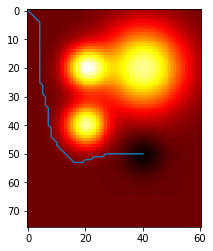

In [419]:
x_pos = []
y_pos = []
for x, y in path:
    x_pos.append(x)
    y_pos.append(y)
plt.plot(x_pos,y_pos)
plt.imshow(arr, cmap='hot', interpolation='nearest')
plt.show()


***????**

Now that we have tackled the problem of searching over a known field we need to address the more pressing challenge. Pathfinding over a unknown field. As described above, the strategy will be to update the map that we are pathfinding over, and then run a* on that. For simplicity we will simply say that the rover takes the next position identified by the a star pathfinding algorithm, and then rescans the environment and repeats the process.

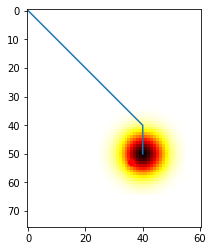

In [420]:
rover_init_postion = (0,0)
ball_location = (36,53) # The actual position of the ball. 
roverWorld = Initialise_tennis_ball_search()

plt.imshow(roverWorld, cmap='hot', interpolation='nearest')
min_index_y, min_index_x = np.argwhere(roverWorld == np.min(roverWorld))[0]
path_new = a_star(roverWorld,(0,0),(min_index_x, min_index_y))
x_pos = []
y_pos = []
for x, y in path_new:
    x_pos.append(x)
    y_pos.append(y)
plt.plot(x_pos,y_pos)
plt.plot(ball_location[0],ball_location[1],"ro")
plt.show()


This the first step in the loop, the red dot on the graph represents the actual position of the tennis ball. To make things more challenging we will add 50 obstacles dotted throughout the region, generated randomly.

We then need to simulate the detection of these obstacles and targets. 

To do this we will use either random or user generated obstacle lists, when the rover is within a certain range of these obstacles the rover adds them to the map. A similar thing happens with the tennis ball, when it is within range the location of the tennis ball is set to be a place of high interest that the rover can navigate to. 

Randomly generating obstacles can be done but they wont necessarily get placed anywhere interesting, so the use can choose to drop them exactly in the path of the rover and then re run the notebook. This leads to more interesting behaviour. 

In [421]:
import random 
random.seed()
# unknown_obstacles = [ ( random.randint(0, 60), random.randint(0, 60) ) for k in range(10) ]
unknown_obstacles = [(7,40)]
unknown = set(unknown_obstacles)

roverLoc = rover_init_postion
def scan(known,obs,pos,tenLoc):
    pos_x, pos_y = pos
    rge = [-3,-2,-1,0,1,2,3]
    n_rows = len(known)
    n_cols = len(known[0])   
    reach = [(pos_x + dx, pos_y + dy) for dx, dy in product(rge,rge)]
    for x, y in reach:

        if (x,y) in obs:
            return applyGaussianToField(known,20,x,y,5)
        elif (x,y) == tenLoc:
            return applyGaussianToField(known,-70,x,y,5)
    
    return known

path = [roverLoc]

We will also add back the obstacles from the earlier sections to the rover map. We will tell the rover about these obstacles ahead of time, we can imagine these as simulating no-go zones that the rover will avoid based on satellite imagery analysis of the competition area.  

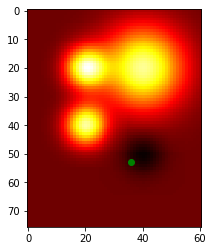

In [422]:
for obstacle in obstacles:
    roverWorld = applyGaussianToField(roverWorld,*obstacle)

plt.imshow(roverWorld, cmap='hot', interpolation='nearest')
plt.plot(ball_location[0],ball_location[1],"ro",color = "Green")
plt.show()

We can see the rovers initial understanding of the environment with the tennis ball position in green shown as well. The rover only has the rough estimate of the tennis ball position given from the rough guassian near it. It does not know the exact location of the tennis ball, only that it is most likely nearby. 

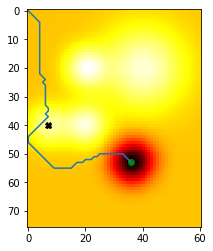

In [423]:
while roverLoc != ball_location:
    roverWorld = scan(roverWorld,unknown,roverLoc,ball_location)
    min_y, min_x = np.argwhere(roverWorld == np.min(roverWorld))[0]
    curr_path = a_star(roverWorld,roverLoc,(min_x,min_y))

    if len(curr_path) == 1:
        break

    roverLoc = curr_path[1]
    path.append(roverLoc)
    

    
plt.imshow(roverWorld, cmap='hot', interpolation='nearest')
plt.plot(ball_location[0],ball_location[1],"ro",color = "Green")
x_pos = []
y_pos = []
for ob in unknown_obstacles:
    plt.plot(ob[0],ob[1],"X",color="black")
for x, y in path:
    x_pos.append(x)
    y_pos.append(y)
plt.plot(x_pos,y_pos)
plt.show()

The path the rover took to reach the final tennis ball is shown in blue and any obstacles added to the field are in black crosses and the rovers final knowledge of the environment. 

We can see that one of the major remaining issues is that the search path does not priorities driving over regions of interest on the way to any given target. This can be addressed by adjusting the heuristic of the a* search algorithm. But that is beyond the scope of this demonstration. 

The purpose was to demonstrate a decision making process for the rover to navigate an environment that it has only partial information about. It assumes a robust target recognition, obstacle detection and robot localisation system.  These will need to be built in order to work.


### Extended Kalman Filter: 
This is a toy implementation of an extended kalman filter for systematic rover localization using a collection of sensors. We will simplify the case to 2D. 


### The General form of a kalman filter
#### Predict 
Assuming an unknown control input (might change this later). We use the current state of the rover to predict how it will change into the future. This state estimate will be fused with extra sensor information later. 
State estimate:
$$
\varkappa_{i+1|i} = F_{i|i} \varkappa_{i|i}  
$$
Error covariance: 
$$
P_{i+1|i} = F_{i|i} P_{i|i}F_{i|i}^T +Q_i
$$

The subscripts denote the step which that estimate refers to and the step which the sensor information comes from respectively. As you can see above they are _predictions_ based on propagating the state from the previous step. And do not integrate any sensor data yet. 
##### Update:
The Kalman filter then does some other stuff. 
$$
\bar{y}_{i+1} = z_{i+1} - H_{i+1} \varkappa_{i+1|i}
$$

$$
S_{i+1} = H_{i+1} P_{i+1|i}H_{i+1}^T + R_{i+1}
$$

$$
K_{i+1} = P_{i+1|i}H_{i+1}^T S^{-1}_{i+1}
$$

$$
\varkappa_{i+1|i+1} = \varkappa_{i+1|i} + K_{i+1} \bar{y}_{i+1} 
$$

$$
P_{i+1|i+1} = (I-K_{i+1}H_{i+1})P_{i+1|i}
$$

$$
\bar{y}_{i+1|i+1}  = z_{i+1} - H_{i+1} \varkappa_{i+1|i+1}
$$

And thats it! The remaining analysis and work is to estimate a few of the matrices introduced withou context above. First we want to create an estimate of the $F_{i|i}$ matrix. It represents a linear mapping of the previous state to the current one. 

To streamline this process of implementing a EKF (which is more advanced than the filter described here) we will borrow a prior toy implementation of a very similar problem from the widely used, cited and loved repo https://atsushisakai.github.io/PythonRobotics/. I cannot recommend looking through this more, it is a phenomenal resource.



I'll skip over the details of the implementation of the filter for our purposes and simply leave the python robotics explanation unmolested. The main change to be made to their implementation of an ekf is the process of how the input is computed. We need to make our rover drive over the path that a-star has specified for us. 

The next thing we need is a model that will generate a control effort based on the current pose of the rover, and its desired pose. Once we have a strong estimation of the rovers pose in 3D we will use the following method to output a desireable actual motion in 2d to move the rover towards the goal. 

In [424]:
def move_to_pose_step(curr,goal):
    """
    This is a simplified version of the 'move_to_pose' routine with
    the key difference that this one is meant to be run in the loop with
    other functions operating around it.
    """
    Kp_rho = 9
    Kp_alpha = 15
    Kp_beta = -3
    dt = 0.01

    x = curr.x
    y = curr.y
    theta = curr.theta
    theta_goal = goal.theta
    x_diff = goal.x - x
    y_diff = goal.y - y

    x_traj, y_traj = [], []

    rho = np.sqrt(x_diff**2 + y_diff**2)

    # Restrict alpha and beta (angle differences) to the range
    # [-pi, pi] to prevent unstable behavior e.g. difference going
    # from 0 rad to 2*pi rad with slight turn

    rho = np.sqrt(x_diff**2 + y_diff**2)
    alpha = (np.arctan2(y_diff, x_diff)
             - theta + np.pi) % (2 * np.pi) - np.pi
    beta = (theta_goal - theta - alpha + np.pi) % (2 * np.pi) - np.pi

    v = Kp_rho * rho
    w = Kp_alpha * alpha + Kp_beta * beta

    if alpha > np.pi / 2 or alpha < -np.pi / 2:
        v = -v
    return [v,w]

The following routine updates the state of the rover so that a ground truth can be established. The imported ekf will then estimate the state of the rover through simulated noisey sensors.  

In [425]:
def update(current,u,w,dt):
    current.theta = current.theta + w*dt
    current.x = current.x + u*np.cos(current.theta) * dt
    current.y = current.y + u*np.sin(current.theta) * dt


With all of these components introduced, lets try driving our rover from one position to another. We will create three instances of the rover class, one that represents the desired state, one that represents the true state, and one that represents the desired state. 

In [426]:
import pose_control
start= [0.0, 0.0, np.pi/4.0]
end = [10.0, 10.0,np.pi]
goal_rover_pose = rover(end[0],end[1],end[2])
true_rover_pose = rover(start[0],start[1],start[2])
est_rover_pose = rover(start[0],start[1],start[2])
dt = 0.01
[v,w] = move_to_pose_step(est_rover_pose, goal_rover_pose)
update(true_rover_pose,v,w,dt)

x_pos = []
y_pos = []

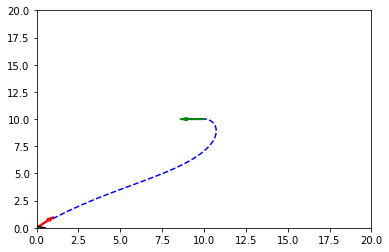

In [427]:
while(abs(true_rover_pose.x-goal_rover_pose.x)>0.01 or abs(true_rover_pose.y-goal_rover_pose.y)>0.01):

    x_pos.append(true_rover_pose.x)
    y_pos.append(true_rover_pose.y)
    [v,w] = move_to_pose_step(true_rover_pose, goal_rover_pose)
    update(true_rover_pose,v,w,dt)

plt.cla()
plt.arrow(start[0],start[1], np.cos(start[2]),
          np.sin(start[2]), color='r', width=0.1)
plt.arrow(end[0], end[1], np.cos(end[2]),
          np.sin(end[2]), color='g', width=0.1)
pose_control.plot_vehicle(start[0],start[1],0,x_pos,y_pos)

The next step is to integrate sampling from the sensors and ekf integration and use that as the state estimate rather than simply passing in the true state.

In [428]:
import ekf

Resetting the state of the rover. 

Now we need to set up a loop that uses the EKF to repeatedly estimate the state of the rover, and then use that for rover postion estimation and therefore velocity and rotation generation. 

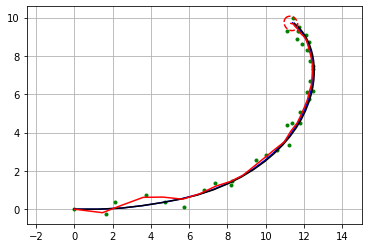

In [440]:
start= [0.0, 0.0, np.pi/4.0]
end = [10.0, 10.0,np.pi]
v = 0 # inital velocity is zero
goal_rover_pose = rover(end[0],end[1],end[2])
true_rover_pose = rover(start[0],start[1],start[2])
est_rover_pose = rover(start[0],start[1],start[2])

PEst = np.eye(4)

xDR = np.zeros((4, 1))  # Dead reckoning
state_est = np.zeros((4,1))
state_true = np.zeros((4,1))
# history
hxEst = state_est
hxTrue = state_true
hxDR = state_true
hz = np.zeros((2, 1))

error = abs(true_rover_pose.x-goal_rover_pose.x) + abs(true_rover_pose.y-goal_rover_pose.y)

ekf.DT = 0.01
while (error>2):
    est_rover_pose.updatestate(state_est)
    true_rover_pose.updatestate(state_true)

    [v,w] = move_to_pose_step(est_rover_pose, goal_rover_pose)
    
    u = np.array([v, w])
    
    state_true, z, xDR, ud = ekf.observation(state_true, xDR, u)

    state_est, PEst = ekf.ekf_estimation(state_est, PEst, z, ud)

    # store data history
    hxEst = np.hstack((hxEst, state_est))
    hxDR = np.hstack((hxDR, xDR))
    hxTrue = np.hstack((hxTrue, state_true))
    hz = np.hstack((hz, z))
    error = abs(true_rover_pose.x-goal_rover_pose.x) + abs(true_rover_pose.y-goal_rover_pose.y)
plt.cla()
plt.plot(hz[0, :], hz[1, :], ".g")
plt.plot(hxTrue[0, :].flatten(),
         hxTrue[1, :].flatten(), "-b")
plt.plot(hxDR[0, :].flatten(),
         hxDR[1, :].flatten(), "-k")
plt.plot(hxEst[0, :].flatten(),
         hxEst[1, :].flatten(), "-r")
ekf.plot_covariance_ellipse(state_est, PEst)
plt.axis("equal")
plt.grid(True)
plt.pause(0.0001)
    

## All together now.
Now that we have a localization and control algorithm weve developed a way to move the rover from one known location. To another known location. The discrete assumption we made above whereby the rover would "jump" from one perfect location in the onboard grid to another can now be discarded. With a few extensions to the algorithm we can pathfind a rover that operates in continuous space on a *discrete* grid. Like it will have to in the real world. 

We will proceed assuming the tennis ball is 100m away from the start and the grid resolution is some tuneable constant. The rover will have an estimated position in terms of   